# Benchmarking Tabular ML Datasets
Thom, Jakob and Marit

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier

## Load in Data

In [41]:
def load_df(filename, foldername='aml-2025-benchmarking-tabular-ml-datasets'):
    return pd.read_csv(f'{foldername}/{filename}', header=0)

In [42]:
covtype_test = load_df('covtype_test.csv')
covtype_train = load_df('covtype_train.csv')
heloc_test = load_df('heloc_test.csv')
heloc_train = load_df('heloc_train.csv')
higgs_test = load_df('higgs_test.csv')
higgs_train = load_df('higgs_train.csv')

# Make all target columns have the name 'label'
covtype_train.rename(columns={'Cover_Type' : 'label'}, inplace=True)
heloc_train.rename(columns={'RiskPerformance' : 'label'}, inplace=True)
higgs_train.rename(columns={'Label' : 'label'}, inplace=True)

# Drop ID column
higgs_train = higgs_train.drop(columns=['EventId'])
higgs_test = higgs_test.drop(columns=['EventId'])

In [43]:
tables_test = [covtype_test, heloc_test, higgs_test]
tables_train = [covtype_train, heloc_train, higgs_train]
names = ['CoverType', 'HELOC', 'Higgs']

In [44]:
def add_task_id(data):
    num_cols = data.shape[1]
    if 'label' in data:
        num_cols -= 1

    if num_cols == 54:
        data['task_id'] = 0 # Covtype 
    elif num_cols == 23:
        data['task_id'] = 1 # Heloc
    elif num_cols == 31:
        data['task_id'] = 2 # Higgs
    else:
        data['task_id'] = 3
        
    return data

In [45]:
covtype_train = add_task_id(covtype_train)
covtype_test = add_task_id(covtype_test)

heloc_train = add_task_id(heloc_train)
heloc_test = add_task_id(heloc_test)

higgs_train = add_task_id(higgs_train)
higgs_test = add_task_id(higgs_test)


## Dealing with Missing Values

In [46]:
# checked by df[df.isna().any(axis=1)], no NaNs in any of the individual datasets


In [47]:
# Covtype seems to have complete data

In [48]:
# Heloc missing values annotated as NEGATIVE INTEGERS, will replace with NaN
heloc_numberic_cols = heloc_train.select_dtypes(include=np.number).columns
heloc_train[heloc_numberic_cols] = heloc_train[heloc_numberic_cols].where(heloc_train[heloc_numberic_cols] >= 0, other=np.nan)

In [49]:
# Higgs missing values annotated as -999.0, will replace with NaN
higgs_train = higgs_train.where(higgs_train != -999.0, other=np.nan)

## Combining Datasets

In [50]:
combined_train = pd.concat([covtype_train, heloc_train, higgs_train], ignore_index = True)
combined_train['task_id'] = combined_train['task_id'].astype('category') # Has to be made a categorical feature, for the model to "catch" it

In [51]:
# Creating a unified target label column, with values from 1-11 (1-7 - Covtype, 8-9 - Heloc, 10-11 - Higgs)

combined_train.loc[combined_train['label'] == 'Bad', 'label'] = 8 # Heloc target coding
combined_train.loc[combined_train['label'] == 'Good', 'label'] = 9 # Heloc target coding

combined_train.loc[combined_train['label'] == 'b', 'label'] = 10 # Higgs target coding
combined_train.loc[combined_train['label'] == 's', 'label'] = 11 # Higgs target coding


## Pipeline Build

In [52]:
# Removed Imputer from before, since we are handling the inidividual datasets missing values separately above (leaving them NaN)
# Could later try mean imputation possibly
unified_pipeline = Pipeline([
    ("clf", LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42
    ))
])

In [53]:
def evaluate_dataset(df, target_col = "label", id_col=None, test_size=0.2, random_state=42, dataset_name=""):

    # Drop ID column if present (dropped it earlier already)
    if id_col is not None and id_col in df.columns:
        df = df.drop(columns=[id_col])

    # Separate features and target
    X = df.drop(columns=[target_col])
    
    unified_columns_list = X.columns.tolist() # This list is needed for making predictions later (column order and nr of columns needs to be the same)

    y = df[target_col]

    # Train / test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # Encode labels (works for Good/Bad, 0/1, 1-7) - labels need to start from 0, that's what the encoder does
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc  = le.transform(y_test)

    # Fit  unified model
    print(f"\n Training unified model on {dataset_name or target_col}")
    unified_pipeline.fit(X_train, y_train_enc)

    # Predict on local test (Validation) set
    y_pred_enc = unified_pipeline.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred_enc)

    trained_model = unified_pipeline.named_steps['clf']

    print(f"Local test accuracy: {acc:.4f}")
    print("Confusion matrix (encoded labels):")
    print(confusion_matrix(y_test_enc, y_pred_enc))

    return le, (X_train, X_test, y_train, y_test), trained_model, unified_columns_list

In [54]:
le_unif, unif_splits, unif_lgbm, unified_columns_list = evaluate_dataset(
    combined_train,
    id_col='EventId',           # leave out id column (removed it before actually, but kept the option in the function)
    dataset_name="Unified"
)


 Training unified model on Unified
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11381
[LightGBM] [Info] Number of data points in the train set: 194011, number of used features: 109
[LightGBM] [Info] Start training from score -2.432527
[LightGBM] [Info] Start training from score -2.150053
[LightGBM] [Info] Start training from score -4.208043
[LightGBM] [Info] Start training from score -6.842951
[LightGBM] [Info] Start training from score -5.560945
[LightGBM] [Info] Start training from score -4.956760
[LightGBM] [Info] Start training from score -4.772000
[LightGBM] [Info] Start training from score -3.896734
[LightGBM] [Info] Start training from score -3.989763
[LightGBM] [Info] Start training from score -0.744269
[LightGBM] [Info] Start training from score -1.400283
[LightGBM] [Wa

## Feature Importance of the Model

In [55]:
# Getting the feature importances from the model
unif_train = unif_splits[0]
features = unif_train.columns
unif_imp = unif_lgbm.feature_importances_

df_unif_feature_imp = pd.DataFrame({
    'Feature': features,
    'Importance': unif_imp
})

df_unif_feature_imp = df_unif_feature_imp.sort_values(by='Importance', ascending=False)

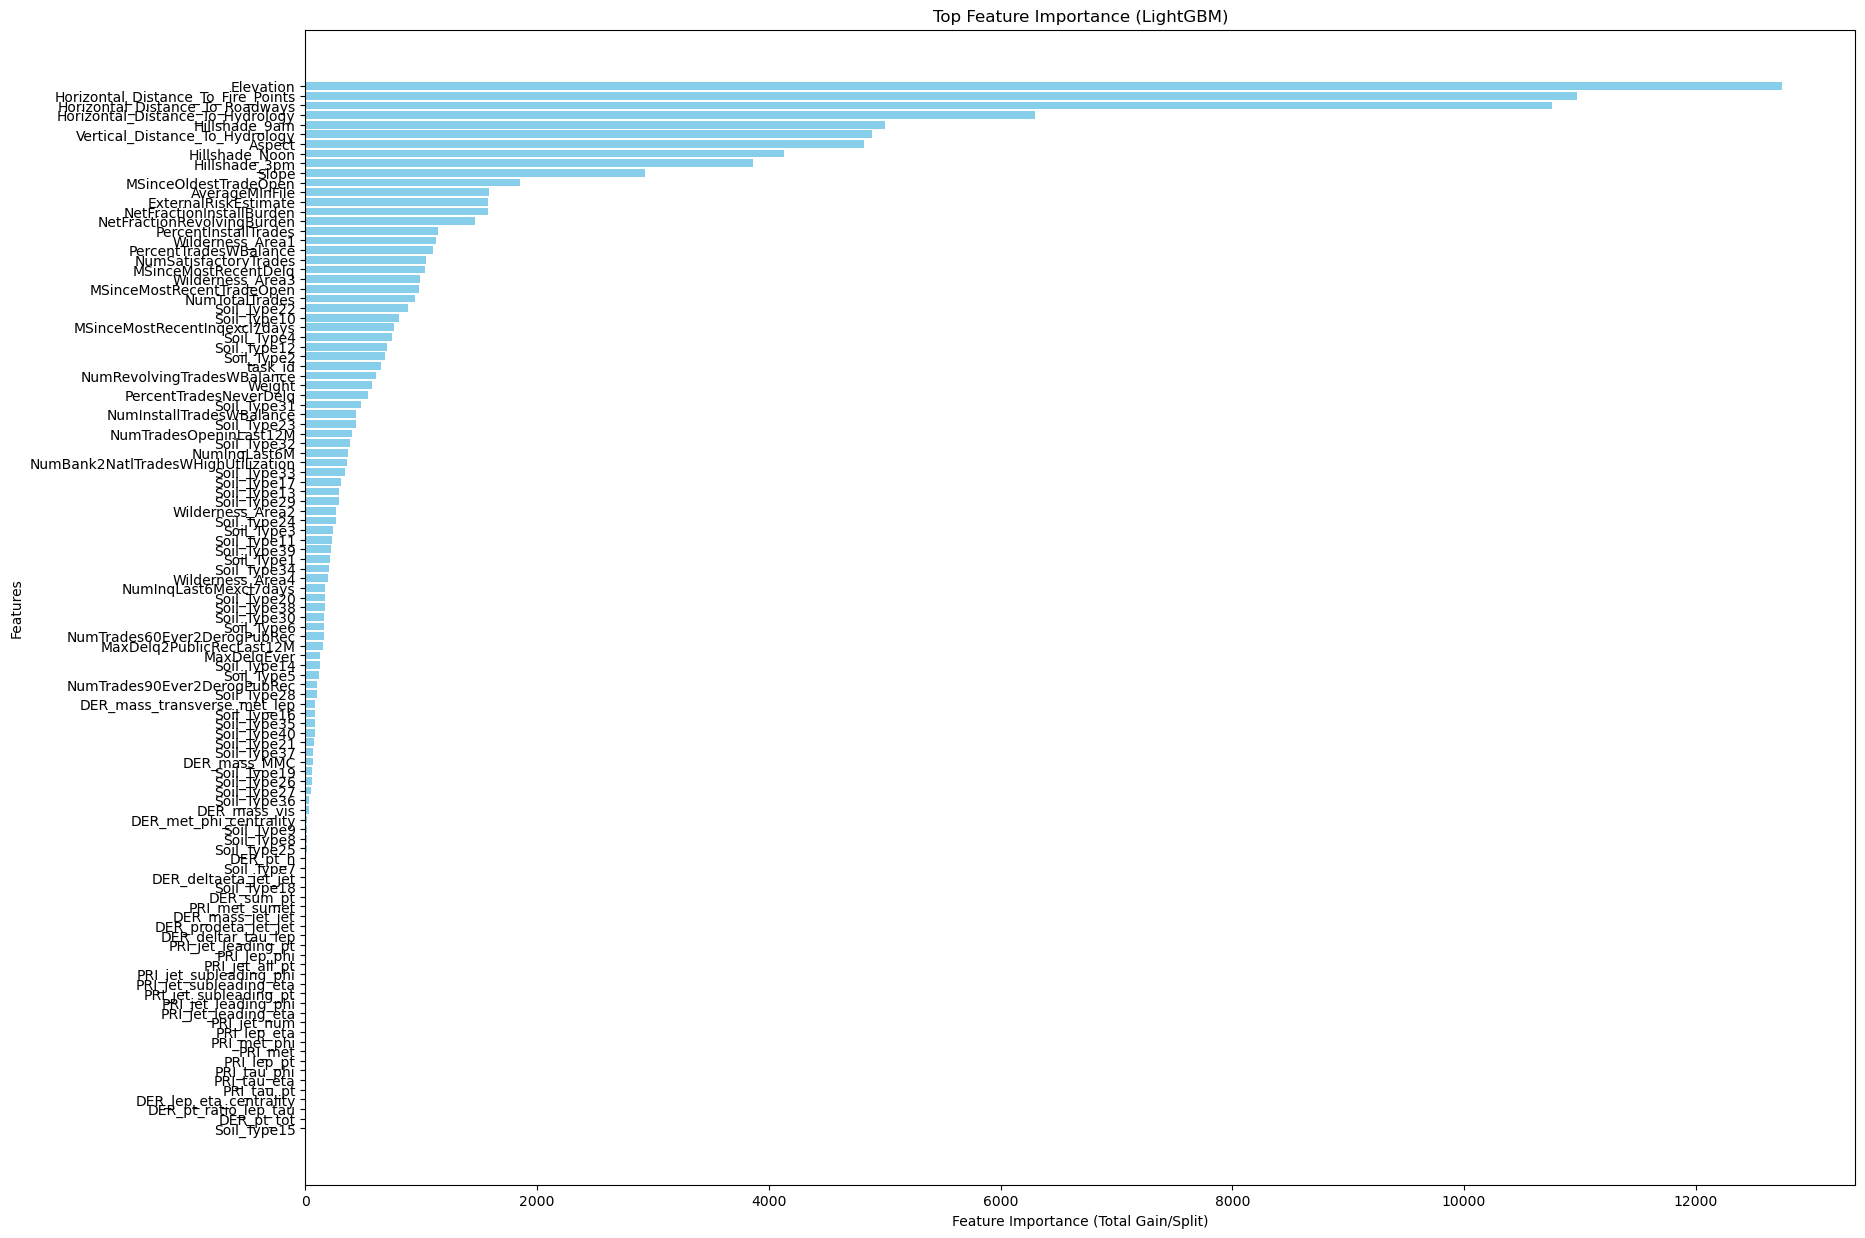

In [56]:
# Plotting feature importances
plt.figure(figsize=(20, 15))
plt.barh(df_unif_feature_imp['Feature'], df_unif_feature_imp['Importance'], color='skyblue')
plt.xlabel("Feature Importance (Total Gain/Split)")
plt.ylabel("Features")
plt.title(f"Top Feature Importance (LightGBM)")
plt.gca().invert_yaxis()
plt.show()

## Test Predictions

In [57]:
# Missing values in test sets (same procedure as above for training data)
heloc_numberic_cols = heloc_test.select_dtypes(include=np.number).columns
heloc_test[heloc_numberic_cols] = heloc_test[heloc_numberic_cols].where(heloc_test[heloc_numberic_cols] >= 0, other=np.nan)
# Higgs missing values annotated as -999.0
higgs_test = higgs_test.where(higgs_test != -999.0, other=np.nan)

In [58]:
def make_predictions(data: pd.DataFrame, pipeline: Pipeline, le: LabelEncoder, feature_cols: list, task_id: int, id_col: str = None) -> pd.DataFrame:
    data_original = data.copy()
    data['task_id'] = task_id
    data['task_id'] = data['task_id'].astype('category')

    if id_col is not None and id_col in data.columns:
        data = data.drop(columns=[id_col])

    for col in feature_cols:
        if col not in data.columns:
            data[col] = np.nan

    data = data[feature_cols]

    y_pred_enc = pipeline.predict(data)

    y_pred_decoded = le.inverse_transform(y_pred_enc)

    results_df = data_original
    results_df['Prediction_Encoded'] = y_pred_enc
    results_df['Prediction'] = y_pred_decoded

    return results_df

In [59]:
# Even though predictions made one-by-one, the data needs to have all the features
# That's why we use the unified_columns_list
# task_id column needed to add the task separator
covtype_results = make_predictions(covtype_test, unified_pipeline, le_unif, unified_columns_list, 0)
heloc_results = make_predictions(heloc_test, unified_pipeline, le_unif, unified_columns_list, 1)
higgs_results = make_predictions(higgs_test, unified_pipeline, le_unif, unified_columns_list, 2)

/var/folders/f4/lmrhcqr10xnbzw52mnqp00x00000gn/T/ipykernel_14453/3427077594.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col] = np.nan
/var/folders/f4/lmrhcqr10xnbzw52mnqp00x00000gn/T/ipykernel_14453/3427077594.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col] = np.nan
/var/folders/f4/lmrhcqr10xnbzw52mnqp00x00000gn/T/ipykernel_14453/3427077594.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

In [60]:
# Combining the results datasets
combined_prediction = pd.concat([covtype_results, heloc_results, higgs_results], ignore_index = True)

### Decoding into correct output format

In [61]:
df_output = combined_prediction[['Prediction']].copy()
df_output['ID'] = df_output.index + 1
df_output[['ID', 'Prediction']].head()

,ID,Prediction
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [62]:
# Covtype will stay as is, values 1-7
# Heloc: 1 'Good' = 9 and 0 'Bad' = 8
# Higgs: 1 's' = 11 and 0 'b' = 10
df_output.loc[df_output['Prediction'] == 8, 'Prediction'] = 0
df_output.loc[df_output['Prediction'] == 9, 'Prediction'] = 1
df_output.loc[df_output['Prediction'] == 10, 'Prediction'] = 0
df_output.loc[df_output['Prediction'] == 11, 'Prediction'] = 1

## Creating output .csv file

In [63]:
output_filename = "combined_test_submission.csv"
df_output[['ID', 'Prediction']].to_csv(output_filename, index=False)
print(f"Successfully created submission file: {output_filename}, DON'T FORGET TO DELETE THE EMPTY LINE FROM END!")


Successfully created submission file: combined_test_submission.csv, DON'T FORGET TO DELETE THE EMPTY LINE FROM END!
